# Predicting Fraudulency based on Job Posts.
1. Visualizing **Missing Values**
2. **WORDCLOUD** on Job Titles
3. **Splitting** Locations into Country, State & City
4. Converting salary ranges into **Min & Max**
5. **Label Encoding** Categorical Features
6. Cleaning Text Features by removing **STOPWORDS** and **Lemmatizing** Words using **NLP**
7. **OVERSAMPLING** Target Variable
8. Scaling Data using **MINMAXSCALER**
9. Plotting **AUC** and **Accuracies** of following Models:
    * **Logistic Regression**
    * **Support Vector Classifier**
    * **MultiLayer Perceptron Classifier**
    * **KNN Classifier**
    * **Decision Tree Classifier**
    * **XGBoost Classifier**
    * **Random Forest Classifier**

# IMPORTING LIBRARIES

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random,matplotlib
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
import nltk as nlp
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
%matplotlib inline

In [2]:
df=pd.read_csv('/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv')
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# Visualizing Missing Values

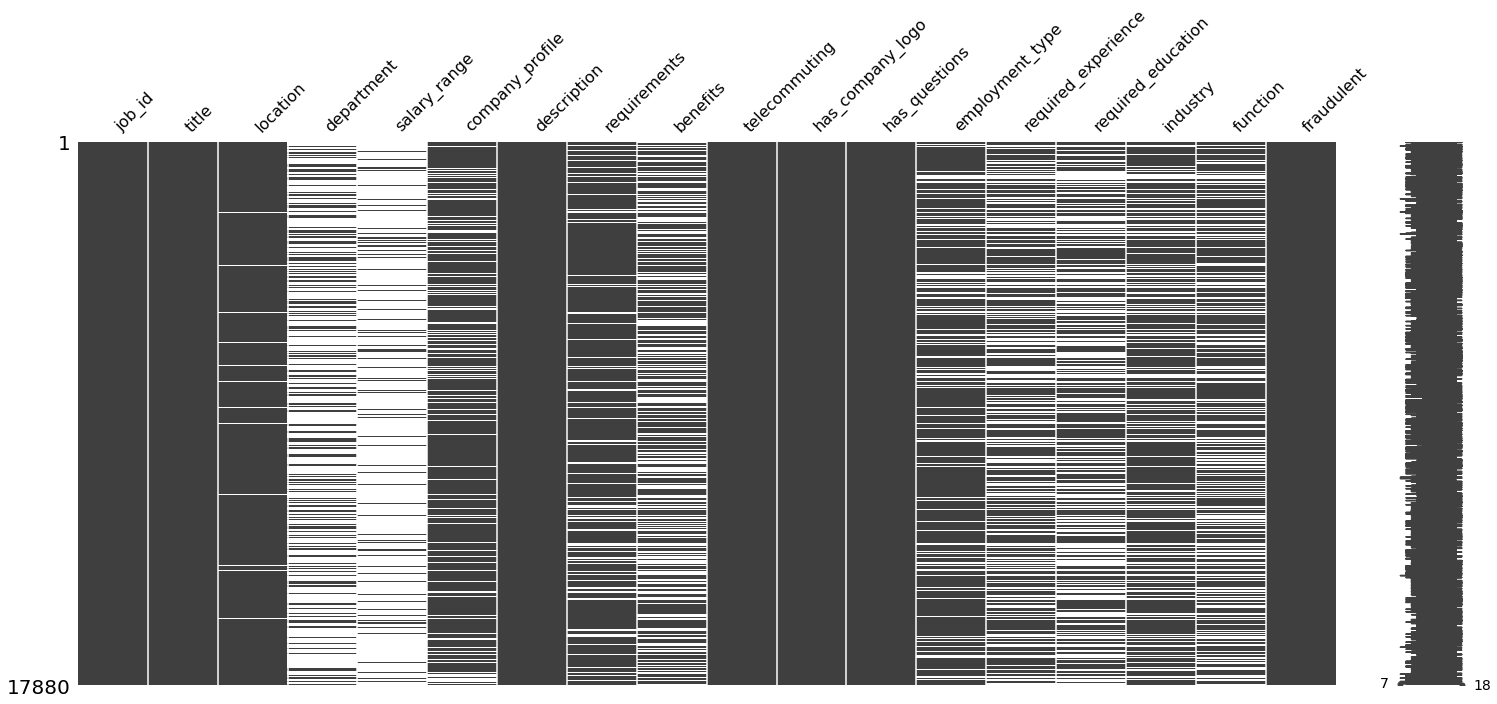

In [3]:
msno.matrix(df)

Plotting Barchart for Missing Values in our dataset

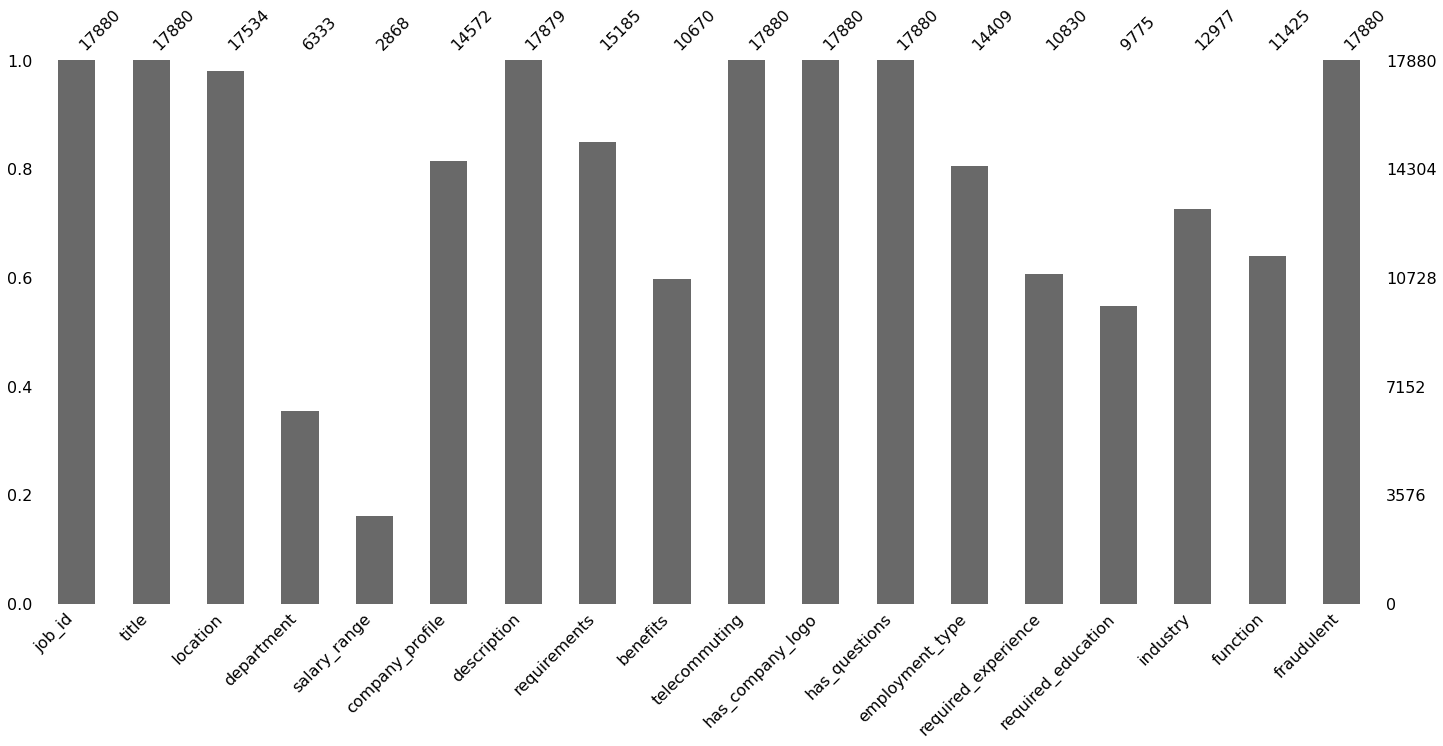

In [4]:
msno.bar(df)

# WORDCLOUD

There are 528001 words in the combination of all available job titles.


(-0.5, 1599.5, 799.5, -0.5)

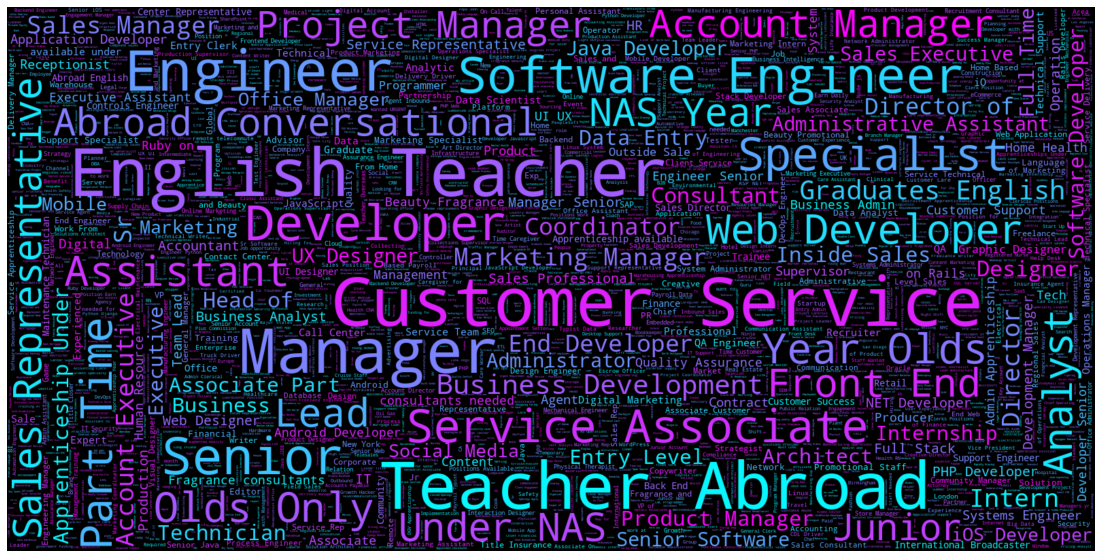

In [5]:
text = " ".join(title for title in df.title)
print ("There are {} words in the combination of all available job titles.".format(len(text)))
stopwords=set(STOPWORDS)
wordcloud = WordCloud(background_color="black",max_font_size=100, max_words=10000,width=1600, height=800,stopwords=stopwords,colormap=matplotlib.cm.cool).generate(text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")

In [6]:
#Dropping 'job_id' as it is irrelevant to fraudulent
df.drop('job_id', axis=1, inplace=True)
text_features = ['title', 'company_profile', 'description', 'requirements', 'benefits']
complex_features = ['location', 'salary_range']
bin_features = ['telecommuting', 'has_company_logo', 'has_questions']
cat_features = ['department', 'employment_type', 'required_experience', 
                'required_education', 'industry', 'function']

In [7]:
df.isnull().sum()

title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

Filling Null values from Text Features with 'Unspecified'

In [8]:
for feature_name in text_features[1:]:
    df[feature_name].fillna('Unspecified', inplace=True)

Filling Null values from location with 'Unspecified' <br>
Splitting location into 3 seperate columns: country, state, city<br>
Dropping location column<br>

# Splitting Locations

In [9]:
location = df['location'].copy()
#splitting location
location_splitted = list(location.str.split(', ').values)
for loc_ind, loc in enumerate(location_splitted):
    if loc is np.nan:
        location_splitted[loc_ind] = ['Unpecified'] * 3
    else:
        for el_ind, el in enumerate(loc):
            if el == '':
                loc[el_ind] = 'Unpecified'
                
location_splitted = list(map(lambda loc: list(loc), location_splitted))
for loc_ind, loc in enumerate(location_splitted):
    if len(loc) > 3:
        location_splitted[loc_ind] = loc[:2] + [', '.join(loc[2:])]
    if len(loc) < 3:
        location_splitted[loc_ind] += ['Unpecified'] * 2
        
data_location = pd.DataFrame(location_splitted, columns=['country', 'state', 'city'])
cat_features += ['country', 'state', 'city']
df= pd.concat([df, data_location], axis=1)
df.drop('location', axis=1, inplace=True)
df.head()

,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,state,city
0,Marketing Intern,Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Unspecified,0,1,0,Other,Internship,NaN,NaN,Marketing,0,US,NY,New York
1,Customer Service - Cloud Video Production,Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ,Unpecified,Auckland
2,Commissioning Machinery Assistant (CMA),NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Unspecified,0,1,0,NaN,NaN,NaN,NaN,NaN,0,US,IA,Wever
3,Account Executive - Washington DC,Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,DC,Washington
4,Bill Review Manager,NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,FL,Fort Worth


# Converting Salary Ranges

Filling Null values from salary_range with '0-0'
Splitting salary_range into 2 seperate columns: min_salary and max_salary
Dropping salary_range

In [10]:
salary_range = df.salary_range.copy()
salary_range.fillna('0-0', inplace=True)
salary_range_sep = list(salary_range.str.split('-').values)
salary_range_sep[5538] = ['40000', '40000']
error_range_inds = []
for range_ind, s_range in enumerate(salary_range_sep):
    min_value, max_value = s_range
    if not min_value.isdigit() or not max_value.isdigit():
        error_range_inds += [range_ind]
for range_ind in error_range_inds:
    salary_range_sep[range_ind] = ['0', '0']
data_salary_range = pd.DataFrame(np.array(salary_range_sep, dtype='int64'), 
                                 columns=['min_salary', 'max_salary'])

num_features = ['min_salary', 'max_salary']
df = pd.concat([df, data_salary_range], axis=1)
df.drop('salary_range', axis=1, inplace=True)
df.head()

,title,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,state,city,min_salary,max_salary
0,Marketing Intern,Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Unspecified,0,1,0,Other,Internship,NaN,NaN,Marketing,0,US,NY,New York,0,0
1,Customer Service - Cloud Video Production,Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ,Unpecified,Auckland,0,0
2,Commissioning Machinery Assistant (CMA),NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Unspecified,0,1,0,NaN,NaN,NaN,NaN,NaN,0,US,IA,Wever,0,0
3,Account Executive - Washington DC,Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,DC,Washington,0,0
4,Bill Review Manager,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,FL,Fort Worth,0,0


Filling Null values from remaining features with 'Unspecified'

In [11]:
df.fillna('Unspecified', inplace=True)

All the null values are cleaned.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   department           17880 non-null  object
 2   company_profile      17880 non-null  object
 3   description          17880 non-null  object
 4   requirements         17880 non-null  object
 5   benefits             17880 non-null  object
 6   telecommuting        17880 non-null  int64 
 7   has_company_logo     17880 non-null  int64 
 8   has_questions        17880 non-null  int64 
 9   employment_type      17880 non-null  object
 10  required_experience  17880 non-null  object
 11  required_education   17880 non-null  object
 12  industry             17880 non-null  object
 13  function             17880 non-null  object
 14  fraudulent           17880 non-null  int64 
 15  country              17880 non-null  object
 16  stat

# Cleaning text using NLP

*clean_text* function to receive column as argument, apply regex functions, tokenizing and lemmatizing and returning the modified dataframe

In [13]:
def clean_text(data):
    description_list = []
    for description in data:
        description = re.sub("[^a-zA-Z]"," ",description)
        description = description.lower()
        description = nlp.word_tokenize(description)
        description = [word for word in description if not word in stopwords]
        lemma = nlp.WordNetLemmatizer()
        description = [lemma.lemmatize(word) for word in description ]
        description =" ".join(description)
        description_list.append(description)
    return description_list

Applying this function on text variables

In [14]:
df['description_cleaned']= clean_text(df.description)
df['company_profile_cleaned']=clean_text(df.company_profile)
df['requirements_cleaned']= clean_text(df.requirements)
df['benefits_cleaned']=clean_text(df.benefits)

Calculating length of each text feature's entries and saving them into feature_length

In [15]:
df['title_length']=df['title'].astype(str).str.split(' ').apply(len)
df['company_profile_length']=df['company_profile_cleaned'].astype(str).str.split(' ').apply(len)
df['benefits_length']=df['benefits_cleaned'].astype(str).str.split(' ').apply(len)
df['description_length']=df['description_cleaned'].astype(str).str.split(' ').apply(len)
df['requirements_length']=df['requirements_cleaned'].astype(str).str.split(' ').apply(len)

# Label Encoding

In [16]:
label=LabelEncoder()
df['employment_type']=label.fit_transform(df['employment_type'])
df['required_experience']=label.fit_transform(df['required_experience'])
df['required_education']=label.fit_transform(df['required_education'])
df['industry']=label.fit_transform(df['industry'])
df['function']=label.fit_transform(df['function'])
df['country']=label.fit_transform(df['country'])
df['state']=label.fit_transform(df['state'])
df['city']=label.fit_transform(df['city'])


Plotting Target Variable

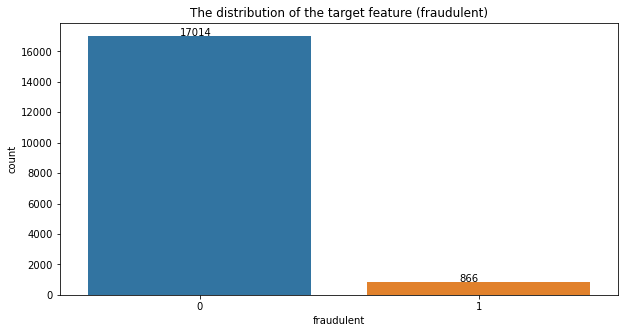

In [17]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(df.fraudulent)
plt.title('The distribution of the target feature (fraudulent)')
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.33, p.get_height()))

# Oversampling Target Variable

In [18]:
data_1f = df[df.fraudulent == 1]
original_data = df.copy()
df = pd.concat([df] + [data_1f] * 7, axis=0)

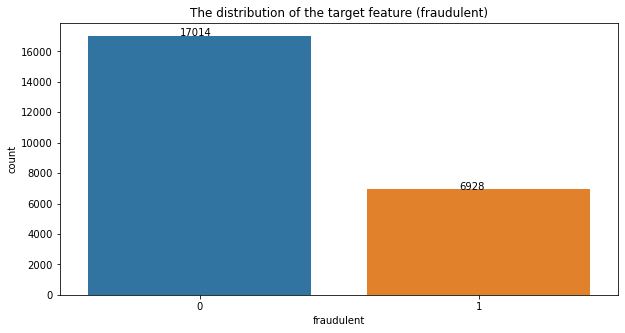

In [19]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(df.fraudulent)
plt.title('The distribution of the target feature (fraudulent)')
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.33, p.get_height()))
plt.show()

Preparing X and y variables by removing unwanted features

In [20]:
X=check=df.drop(['title','department','company_profile','description','requirements','benefits','description_cleaned','company_profile_cleaned','requirements_cleaned','benefits_cleaned','fraudulent'],axis=1)
y=df.fraudulent

In [21]:
X

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,country,state,city,min_salary,max_salary,title_length,company_profile_length,benefits_length,description_length,requirements_length
0,0,1,0,2,4,9,123,22,85,227,1457,0,0,2,92,1,84,76
1,0,1,0,1,6,9,75,7,60,293,188,0,0,6,157,111,208,133
2,0,1,0,5,7,9,123,36,85,155,2213,0,0,4,81,1,31,126
3,0,1,0,1,5,1,22,31,85,104,2164,0,0,5,58,77,230,124
4,0,1,1,1,5,1,51,16,85,130,786,0,0,3,169,3,132,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17827,0,0,0,3,7,9,123,36,85,83,1204,0,0,5,1,1,52,1
17828,0,0,1,5,7,9,123,36,5,221,2026,0,0,2,1,29,24,55
17829,0,0,0,5,7,9,123,36,65,203,2161,0,0,2,1,17,39,94
17830,0,0,0,1,7,9,4,0,85,227,1457,0,0,3,1,18,33,23


In [22]:
y

0        0
1        0
2        0
3        0
4        0
        ..
17827    1
17828    1
17829    1
17830    1
17831    1
Name: fraudulent, Length: 23942, dtype: int64

# SCALING DATA with MINMAXSCALER

In [23]:
scaler=MinMaxScaler()
X=scaler.fit_transform(X)

X

# MODELING
**1. LOGISTIC REGRESSION** <br>
**2. XGBOOST**<br>
**3. Logistic Regression**<br>
**4. Support Vector Classifier**<br>
**5. MultiLayer Perceptron Classifier**<br>
**6. KNN Classifier**<br>
**7. Decision Tree Classifier**<br>
**8. XGBoost Classifier**<br>
**9. Random Forest Classifier**<br>

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42)

Creating a function 'roc_plotter' for passing model object, model name and plotting its roc auc curve with accuracy

In [25]:
def roc_plotter(model_object,model_name):     
        model_object.fit(X_train, y_train)
        y_pred=model_object.predict(X_test)
        ns_probs = [0 for _ in range(len(y_test))]

        # predict probabilities
        model_probs = model_object.predict_proba(X_test)[:, 1]

        # calculate scores
        ns_auc = roc_auc_score(y_test, ns_probs)
        model_auc = roc_auc_score(y_test, model_probs)
    
        fig = plt.figure(figsize=(12,5))

        # calculate roc curves
        ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
        lr_fpr, lr_tpr, _ = roc_curve(y_test, model_probs)
        # plot the roc curve for the model
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)

        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        # show the legend
        plt.legend()
        # show the plot
        score= accuracy_score(y_test, y_pred)
        txt1='ROC AUC = {}'.format(round(model_auc,2))
        txt2='Accuracy = {}%'.format(round(score*100,2))
        
        plt.text(0.3,0.2,model_name,fontsize=25, fontweight='bold',color='red')
        plt.text(0.3,0.1,txt1,bbox={'facecolor': 'orange','pad': 10},fontsize=15)
        plt.text(0.5,0.1,txt2,bbox={'facecolor': 'red', 'pad': 10},fontsize=15,color='white')
        plt.tight_layout()

# Logistic Regression

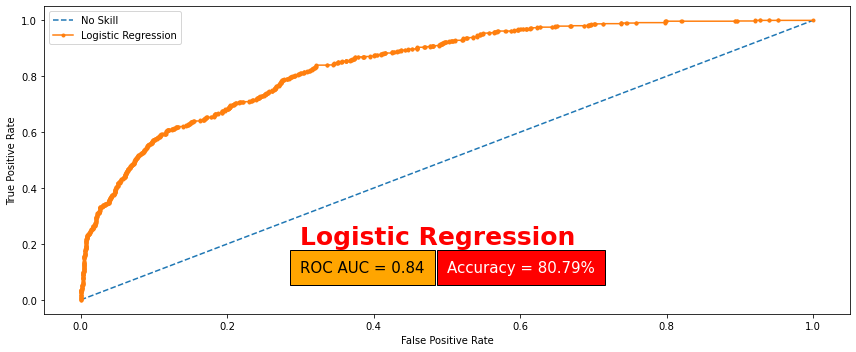

In [26]:
lrmodel=LogisticRegression()
roc_plotter(lrmodel,'Logistic Regression')

# Support Vector Classifier

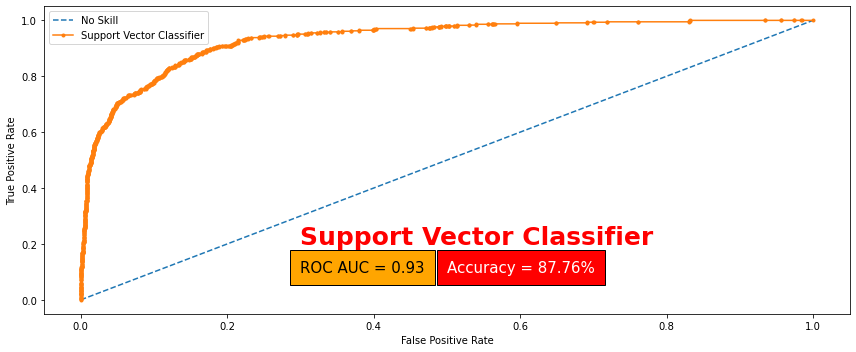

In [27]:
svmmodel=SVC(probability=True)
roc_plotter(svmmodel,'Support Vector Classifier')

# MultiLayer Perceptron Classifier

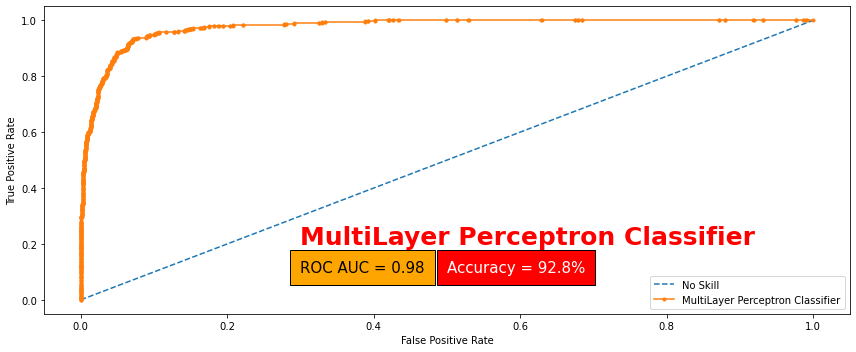

In [28]:
nnmodel=MLPClassifier()
roc_plotter(nnmodel,'MultiLayer Perceptron Classifier')

# KNN Classifier

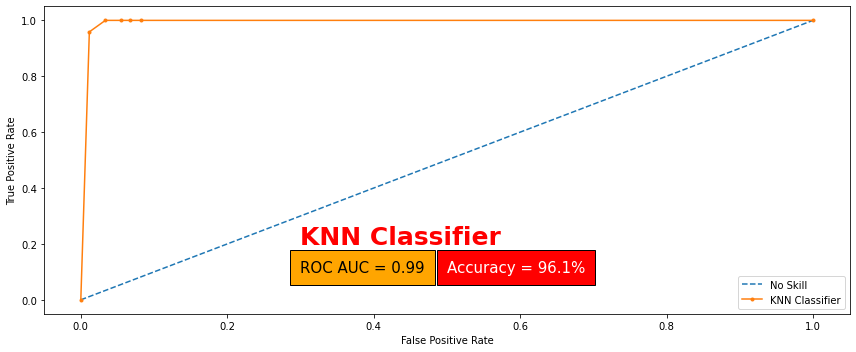

In [29]:
knnmodel=KNeighborsClassifier()
roc_plotter(knnmodel,'KNN Classifier')

# Decision Tree Classifier

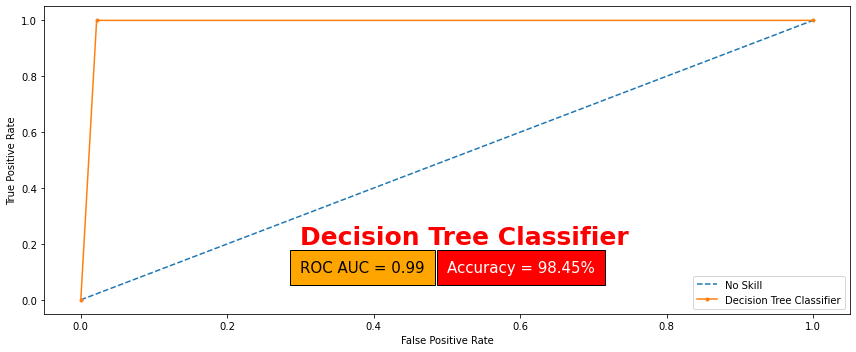

In [30]:
dtmodel=DecisionTreeClassifier()
roc_plotter(dtmodel,'Decision Tree Classifier')

# XGBoost Classifier

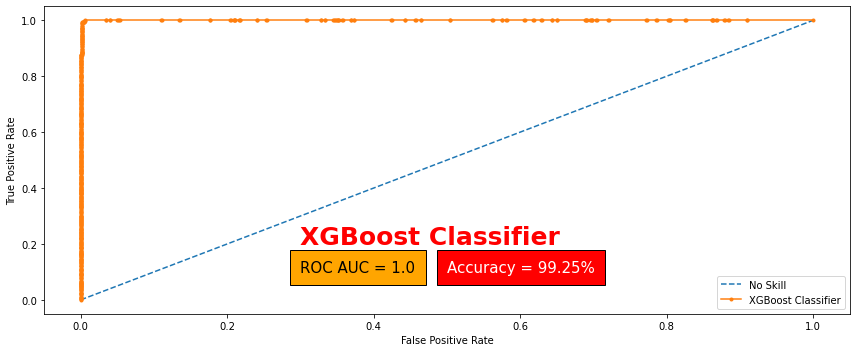

In [31]:
xgb = XGBClassifier()
roc_plotter(xgb,'XGBoost Classifier')

# Random Forest Classifier

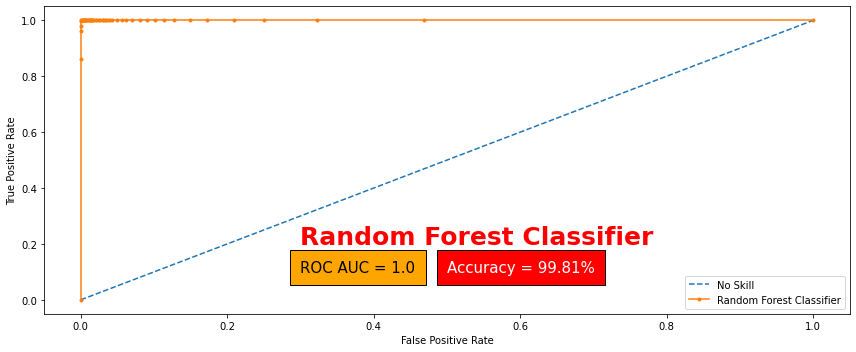

In [32]:
rfmodel=RandomForestClassifier()
roc_plotter(rfmodel,'Random Forest Classifier')

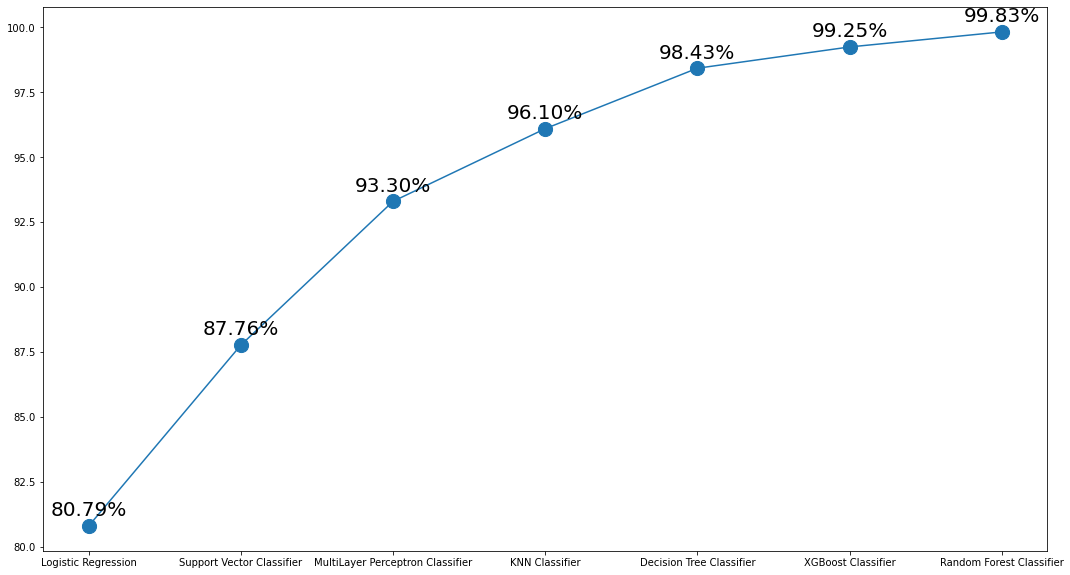

In [33]:
models=['Logistic Regression','Support Vector Classifier','MultiLayer Perceptron Classifier','KNN Classifier','Decision Tree Classifier','XGBoost Classifier','Random Forest Classifier']
accuracies=[80.79,87.76,93.3,96.1,98.43,99.25,99.83]
plt.figure(figsize=(18,10))
plt.scatter(x=models, y=accuracies,s=200)
plt.plot(models,accuracies)
for x,y in zip(models,accuracies):
    label = "{:.2f}%".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center',fontsize=20)